# Real HW experiments - Primitives

In [1]:
import numpy as np
import pandas as pd
import itertools

from qiskit import Aer, transpile, QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.data_preparation import StatePreparation

import warnings
warnings.filterwarnings("ignore")

### Utils

In [2]:
def phase_estimation(matrix, qram_circuit, resolution):
    """
    For a generic 2**n matrix, the corrisponding Quantum Phase Estimation for integer eigenvalues extraction 

    Input parameters: 
        - matrix: generic matrix as numpy matrix ( 2^N shape )
        - qram_circuit: preprocessing circuit
        - replicate_paper: boolean parameter, recreate 2x2 matrix used in reference paper
        - eigval_list: list of eigenvalues generated for testing purposes
    Output :
        - resolution: number of qubits used to represent the computed eigenvalues
        - pe : phase estimation circuit
    """

    #Unitary Operator for PE
    u_circuit = NumPyMatrix(matrix, evolution_time=2*np.pi)

    #PE circuit
    pe = PhaseEstimation(resolution, u_circuit, name = "PE")

    num_qubit = resolution+int(np.ceil(np.log2(len(matrix)**2)))

    pe_register = QuantumRegister(num_qubit, 'total')

    pe_circuit = QuantumCircuit(pe_register)

    pe_circuit.append(qram_circuit.to_gate(), pe_register[resolution:])
    pe_circuit.append(pe.to_gate(), pe_register[0:pe.num_qubits])

    return pe_circuit

def check_statevector(backend, pe_circuit, resolution, example_matrix):
    pe_job = backend.run(transpile(pe_circuit, backend=backend))
    statevector = np.asarray(pe_job.result().get_statevector()).round(3)

    bitstrings = [''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
    statevector_dict = {}
    for bitstring, amplitude in zip(bitstrings, statevector):
        statevector_dict[bitstring] = amplitude
    return statevector_dict

In [3]:
from scipy.signal import find_peaks

def eigen_estimation(probabilities, sign_dictionary, resolution, debug=False):
    """
    Estimate eigenvalues and eigenvectors from the input matrix and the relative output of state tomography 

    Input parameters: 
        - probabilities: the probabilities for each state obtained from tomography
        - sign dictionary: the signs of the reconstructed (via tomography) statevector
        - resolution: number of qubits used to represent the computed eigenvalues
    Output :
        - eigenvalues: eigenvalues of the input matrix
        - eigenvectors: eigenvectors of the input matrix
    """

    df = pd.DataFrame.from_dict(probabilities, orient='index')
    df.reset_index(inplace=True)
    df.columns=['state', 'module']

    df['lambda']=df['state'].apply(lambda x: x[-resolution:])
    df1=df.groupby('lambda').agg({'module':'sum'})
    #df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
    df1=df1.sort_values('module',ascending=False)
    df1.reset_index(inplace=True)
    df1['num']=df1['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

    peaks=[]
    nums_peaks=[]

    for i in range(0,2):
        df1.sort_values(['module'], ascending=False, inplace=True)
        el = df1.iloc[i]
        nums_peaks.append(el['num'])
        peaks.append(el['lambda'])

    if debug == True:
        print(peaks, nums_peaks)
        df1[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

    df.columns=['state','module','lambda']
    df['sign']=np.array(list(sign_dictionary.values()))
    df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
    df=df.fillna(0)

    a=[]
    save_sign=[]
    eigenvalues=[]
    for l in peaks:
        eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
        a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
        #print(a_)
        save_sign.append(np.sign(a_))
        #print(save_sign)
        
        a.append(np.sqrt(abs(a_)))

    #a=[a1,a2]

    for i in range(len(a)):
        # print(a[i])
        normalization_factor=np.sqrt((1/(sum(a[i]**2))))
        # print(normalization_factor)
        a[i]*=normalization_factor
        a[i]*=save_sign[i]

    len_eigenvector = len(list(probabilities.keys())[0])-resolution
    eigenvectors=[]
    for ll, eig in zip(a, eigenvalues):
        
        eigenvector=np.zeros(len_eigenvector) #put length of eigenvector
        save_sign=np.sign(ll)
        sv=abs(ll)
        max_list=[]
        scaled_statevectors=[]
        for e,i in enumerate(range(0,len(sv), len_eigenvector)):
            max_list.append(max(sv[i:i+len_eigenvector]))
            scaled_statevectors.append(sv[i:i+len_eigenvector]/max_list[e])
            #print(max_list,scaled_statevectors)
        idx_max=np.argmax(max_list)
        #print(idx_max)
        max_max=max_list[idx_max]
        #print(max_max)
        value=np.sqrt(max_max)
        #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
        eigenvector=scaled_statevectors[idx_max]*value*save_sign[len_eigenvector*idx_max:len_eigenvector*idx_max+len_eigenvector]
        eigenvectors.append((eig, eigenvector))

    return eigenvectors


In [4]:
def sign_estimation(pe_circuit, probabilities, n_shots):
    """
    Estimate signs for the circuit's statevector

    Input parameters: 
        - pe_circuit: circuit that performs phase estimation
        - probabilities: the probabilities for each state obtained from tomography
        - n_shots: number of shots
    Output :
        - sign_dictionary: dictionary containing the signs
    """

    # Create the first operator for tomography
    pe_circuit.remove_final_measurements()
    op_U = pe_circuit.to_gate(label='op_U').control()
    #Create the second operator for tomography
    op_V = StatePreparation(np.sqrt(list(probabilities.values())),label='c_V').control()

    qr_target = QuantumRegister(pe_circuit.num_qubits, 'target')
    qr_control = QuantumRegister(1, 'control_qubit')

    sign_estimation_circuit = QuantumCircuit(qr_target, qr_control, name='sign_estimation')
    sign_estimation_circuit.h(qr_control)
    sign_estimation_circuit.x(qr_control)

    sign_estimation_circuit.append(op_U, qr_control[:]+qr_target[:])
    sign_estimation_circuit.x(qr_control)
    sign_estimation_circuit.append(op_V, qr_control[:]+qr_target[:])
    sign_estimation_circuit.h(qr_control)
    sign_estimation_circuit.measure_all()

    transpiled_circuit = transpile(sign_estimation_circuit, backend=backend_real)
    print(transpiled_circuit.depth())
    job_for_sign = backend_real.run(transpiled_circuit, shots=n_shots)
    counts_for_sign = job_for_sign.result().get_counts()

    #Take only counts with control qubits equal to 0
    tmp=np.zeros(2**pe_circuit.num_qubits)
    for c in counts_for_sign:
        if c[0]=='0':
            tmp[int(c[1:],2)]=counts_for_sign[c]
    
    #Sign estimation
    sign_dictionary={}
    sign=0
    for e, (count, prob) in enumerate(zip(tmp, probabilities.values())):
        if count>0.5*prob*n_shots:
            sign=1
        else:
            sign=-1
        if prob==0:
            sign=1
        sign_dictionary.update({bin(e)[2:].zfill(pe_circuit.num_qubits):sign})
    
    return sign_dictionary, counts_for_sign

## Main

#### Preprocessing 

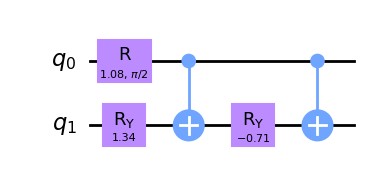

In [5]:
from qiskit.circuit.library import StatePreparation

arr = [0.6507, 0.2122, 0.2122, 	0.3493]
mat_arr = np.array([[0.6507, 0.2122], [0.2122, 0.3493]])
# arr = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3]
# arr = [i for i in range(1,65)]

norm = np.linalg.norm(arr)
SP = StatePreparation(arr / norm)

num_qubits = int(np.sqrt(len(arr)))
qc = QuantumCircuit(num_qubits)

qc.append(SP, [i for i in range(num_qubits-1,-1,-1)])
qc.decompose(reps=4).draw("mpl")


#### Phase Estimation

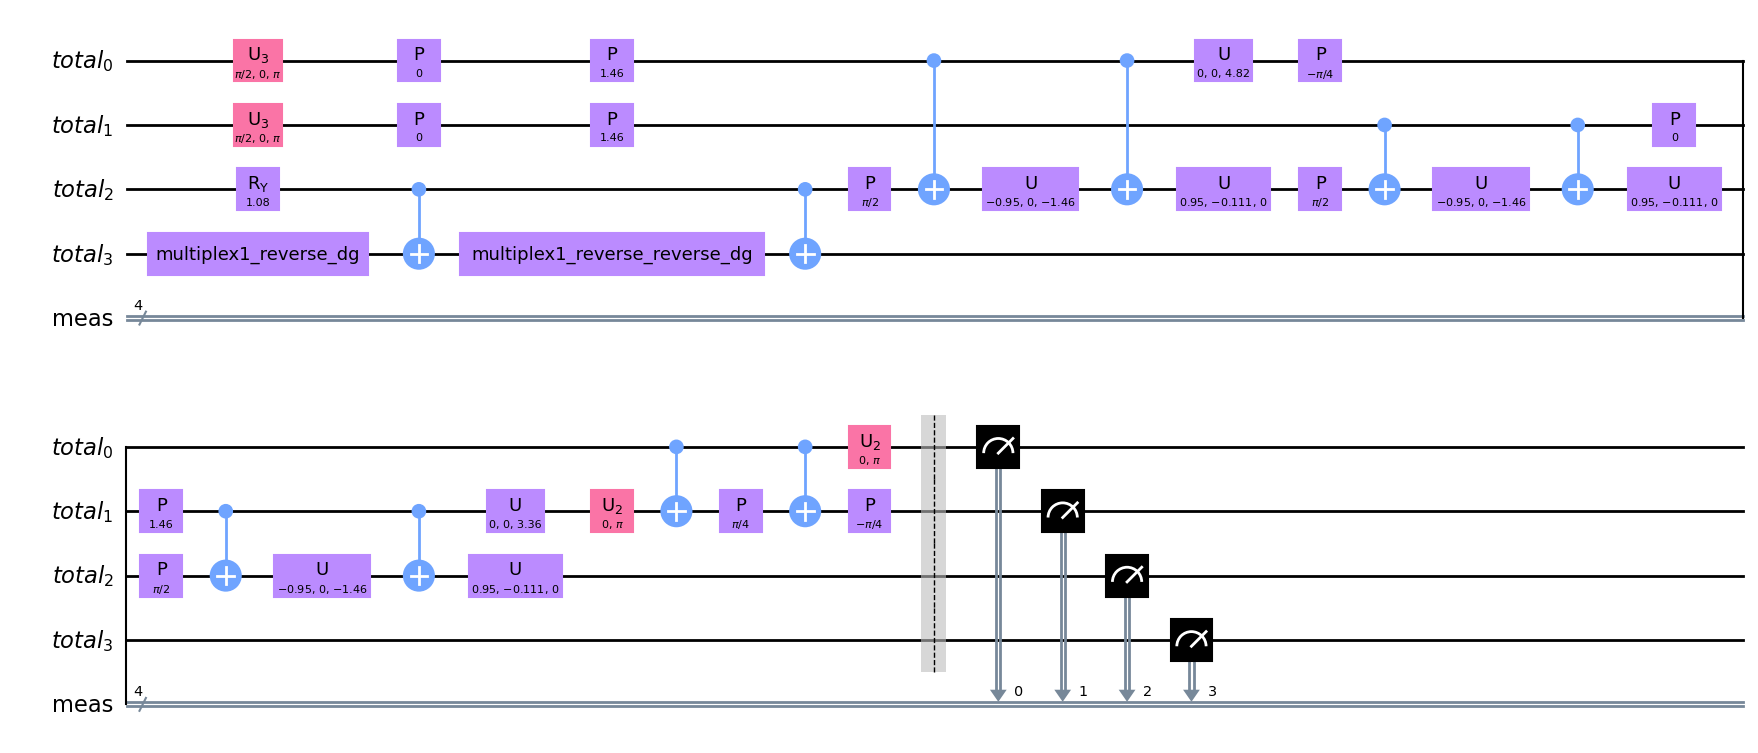

In [6]:
# Create and Add Phase estimation block to circuit
resolution = 2
pe_circuit = phase_estimation(mat_arr, qc, resolution)
pe_circuit.measure_all()
# print(exact_statevector)
pe_circuit.decompose(reps=4).draw("mpl")

#### Quantum State Tomography - Probability amplitude estimation

In [14]:
from qiskit.providers.fake_provider import FakeLagosV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

n_shots = 50000 # Increase to achieve higher accuracy

service = QiskitRuntimeService(channel="ibm_quantum")

backend_real = service.backend('ibmq_belem')
fake_backend = FakeLagosV2()

sampler = Sampler(session=backend_real)


# backend_simulation = Aer.get_backend("qasm_simulator")
transpiled = transpile(pe_circuit, backend=backend_real, optimization_level=3, seed_transpiler=42)
print("Depth: ", transpiled.depth())
job = sampler.run(transpiled, shots=n_shots)

In [55]:
print(service.backends())

[<IBMBackend('ibmq_belem')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibm_oslo')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>]


In [15]:
dist = job.result().quasi_dists[0]
counts = {}
for (key,value) in dist.items():
    counts[format(key, '04b')] = value
# print(transpiled.depth())
plot_histogram(counts)

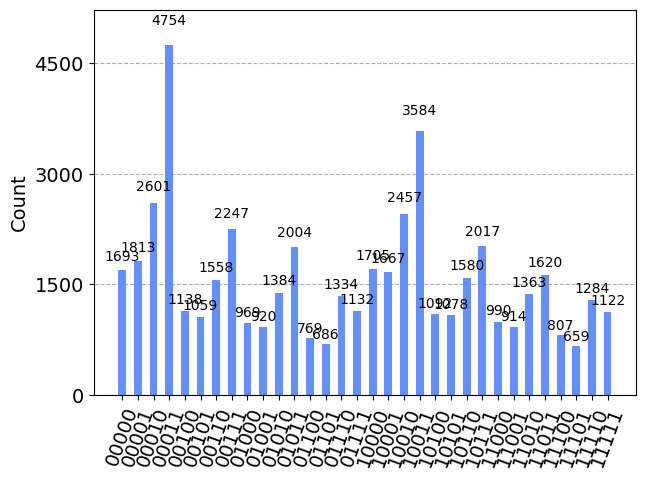

In [142]:
# Reconstruct the probabilities of observing each state from the counts provided by the simulation, plus perform the sign tomography

probabilities = {}

for i in range(2**pe_circuit.num_qubits):
    binary_i = bin(i)[2:].zfill(pe_circuit.num_qubits)
    try:
        # Will approximate the modulus two of the values seen in exact_statevector, two cells above
        probabilities[binary_i] = counts[binary_i]/n_shots
    except KeyError:
        probabilities[binary_i] = 0.0

sign_dictionary, counts_for_sign = sign_estimation(pe_circuit, probabilities, n_shots)


In [144]:
print("Quantum method results:")
result = eigen_estimation(probabilities, sign_dictionary, resolution, debug=False)

for eig, eigenvector in result:
    print(f'eigenvalue: {eig} - eigenvector: {np.real(eigenvector).round(3)}')

Quantum method results:
eigenvalue: 0.75 - eigenvector: [-0.882 -0.468]
eigenvalue: 0.25 - eigenvector: [ 0.496 -0.824]


Note: 

1) The signs of the eigenvectors are arbitrary. 
You can flip them without changing the meaning of ther result; only their direction matters.

2) One can improve the accuracy of the algorithm increasing the *resolution* parameter and the number of shots

In [145]:
print("Classically computed values:")
zipped_list = list(zip(np.linalg.eig(mat_arr)[0][::-1], np.rot90(np.linalg.eig(mat_arr)[1])))
for eigenval, eigenvec in sorted(zipped_list, key = lambda x: x[0], reverse=True):
    print(f'eigenvalue: {eigenval:.4f} - eigenvector: {eigenvec.round(5)}')

Classically computed values:
eigenvalue: 0.7603 - eigenvector: [0.88854 0.45879]
eigenvalue: 0.2397 - eigenvector: [-0.45879  0.88854]
